Install the required libraries

In [ ]:
# !pip install opencv-python

In [ ]:
# !pip3 uninstall --yes torch torchaudio torchvision torchtext torchdata
# !pip3 install torch torchaudio torchvision torchtext torchdata

In [ ]:
# !pip install git+https://github.com/facebookresearch/segment-anything.git

In [4]:
# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


Importing the libraries

In [15]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

Img credit : https://www.pexels.com/photo/bird-s-eye-view-of-river-in-middle-of-green-fields-1483880/

In [6]:
image = cv2.imread('/content/fields.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

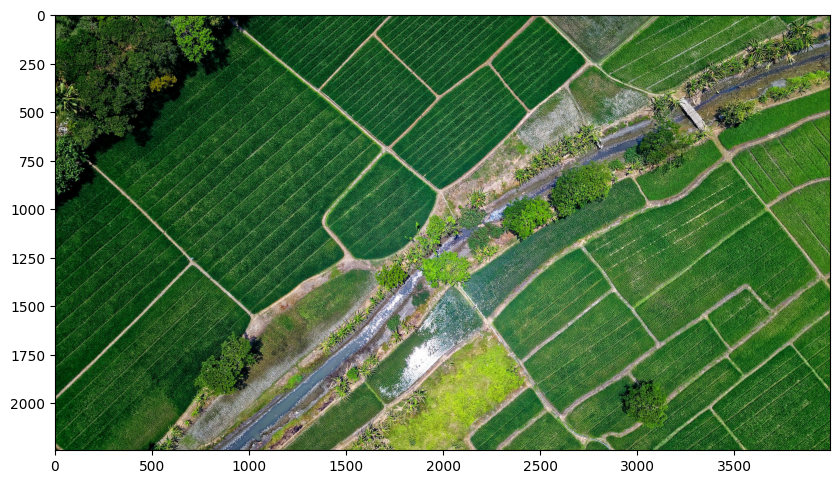

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

In [8]:
sam_model_checkpoint_path = '/content/drive/MyDrive/sam_vit_h_4b8939.pth'
model_type = 'vit_h'
device = 'cuda'

sam = sam_model_registry[model_type](checkpoint=sam_model_checkpoint_path)
sam.to(device=device)

predictor = SamPredictor(sam)

In [9]:
predictor.set_image(image)

1. Point-based mask generation

In [10]:
point_coords = np.array([[900, 600]])   # (x, y)
point_labels = np.array([1])            # 1 = foreground

masks, scores, _ = predictor.predict(
    point_coords=point_coords,
    point_labels=point_labels,
    multimask_output=True
)

point_mask = masks[np.argmax(scores)]

2. Polygon-based mask generation

In [12]:
polygon_points = np.array([
    [700, 400],
    [1100, 400],
    [1100, 800],
    [700, 800]
])

polygon_labels = np.ones(len(polygon_points))

masks, scores, _ = predictor.predict(
    point_coords=polygon_points,
    point_labels=polygon_labels,
    multimask_output=False
)

polygon_mask = masks[0]

3. Automated Entire Image Mask Generation

In [16]:
auto_mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.92,
    min_mask_region_area=500
)

auto_masks = auto_mask_generator.generate(image)


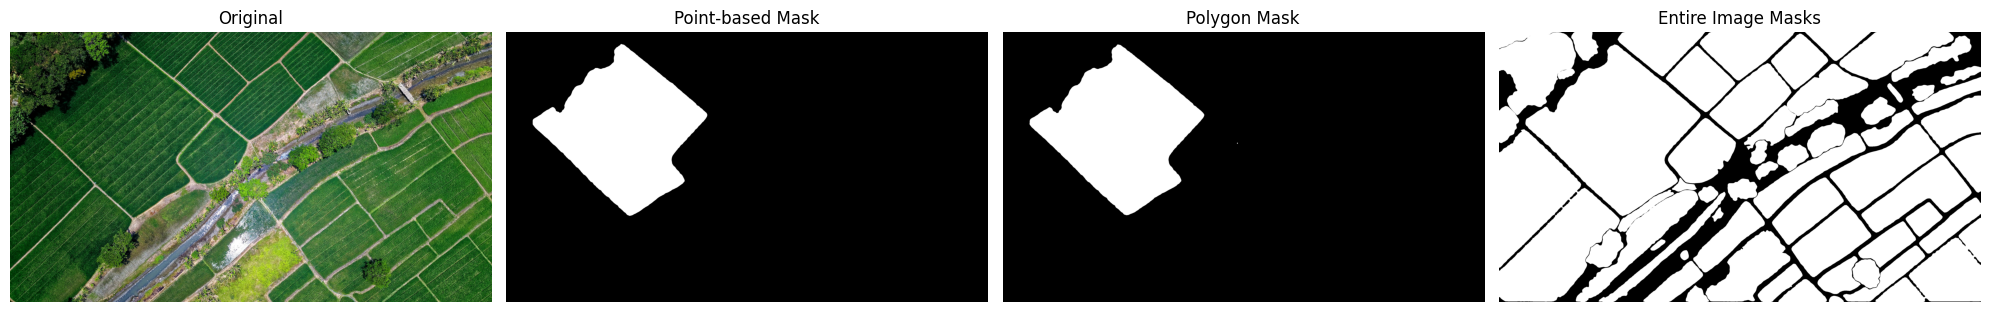

In [17]:

# create a visualization mask
full_mask = np.zeros(image.shape[:2], dtype=np.uint8)
for m in auto_masks:
    full_mask[m["segmentation"]] = 255

# =========================================================
# VISUALIZATION
# =========================================================
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

axs[0].imshow(image)
axs[0].set_title("Original")
axs[0].axis("off")

axs[1].imshow(point_mask, cmap="gray")
axs[1].set_title("Point-based Mask")
axs[1].axis("off")

axs[2].imshow(polygon_mask, cmap="gray")
axs[2].set_title("Polygon Mask")
axs[2].axis("off")

axs[3].imshow(full_mask, cmap="gray")
axs[3].set_title("Entire Image Masks")
axs[3].axis("off")

plt.tight_layout()
plt.show()

Saving the masks

In [21]:
from PIL import Image
import numpy as np

# Convert boolean mask to uint8 (0 or 255)
point_mask_img = (point_mask * 255).astype(np.uint8)
Image.fromarray(point_mask_img).save("point_mask.png")

# Convert boolean mask to uint8 (0 or 255)
polygon_mask_img = (polygon_mask * 255).astype(np.uint8)
Image.fromarray(polygon_mask_img).save("polygon_mask.png")

# Auto mask seperate entities
for i, mask_dict in enumerate(auto_masks):
    mask = mask_dict['segmentation']  # binary mask
    mask_img = (mask * 255).astype(np.uint8)
    Image.fromarray(mask_img).save(f"auto_mask_{i}.png")

# Auto mask entire image
H, W = auto_masks[0]['segmentation'].shape
combined_mask = np.zeros((H, W), dtype=bool)

for mask_dict in auto_masks:
    combined_mask |= mask_dict['segmentation']  # union of masks

# Convert to uint8 and save
combined_mask_img = (combined_mask * 255).astype(np.uint8)
Image.fromarray(combined_mask_img).save("auto_mask_combined.png")